Often times we are interested in summarizing a collection of images into a single image. Reducers in Google Earth Engine (GEE) are functions that aggregate data, enabling the computation of summary metrics over images, image collections, or features. Reducers can summarize data spatially, temporally, or across bands, making them powerful tools for analyzing and synthesizing large geospatial datasets.


In [3]:
# Import modules
import ee
import numpy as np
import pandas as pd
import requests
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps


In [4]:
# Authenticate
#ee.Authenticate()

# Initialize GEE API
ee.Initialize()


## Define helper functions

In [5]:
# Define function to save images to the local drive 
def save_geotiff(ee_image, filename, crs, scale, geom, bands=[]):
    """
    Function to save images from Google Earth Engine into local hard drive.
    """
    image_url = ee_image.getDownloadUrl({'region': geom,'scale':scale, 
                                         'bands': bands,
                                         'crs': f'EPSG:{crs}', 
                                         'format': 'GEO_TIFF',
                                         'formatOptions': {'cloudOptimized': True,
                                                           'noDataValue': 0}})
    
    # Request data using URL and save data as a new GeoTiff file
    response = requests.get(image_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
        return print('Saved image')

## Example 1: Sum reducers

The sum reducer adds up all the values it encounters. This is useful for calculating total rainfall, snowfall, or any other cumulative measure over an area. IN this example we will compute the annual precipitation in 2023 across Oklahoma.


In [6]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
region = US_states.filter(ee.Filter.eq('NAME','Oklahoma'))

# Create mask
mask = ee.Image.constant(1).clip(region).mask()

In [49]:
prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').filterDate('2023-01-01', '2023-12-31')
precip_img = prism.select('ppt').reduce(ee.Reducer.sum()).mask(mask)


In [50]:
# Save geotiff
precip_filename = '../outputs/oklahoma_rainfall_2023.tif'
save_geotiff(precip_img, precip_filename, crs=4326, scale=4_000, geom=region.geometry())


Saved image


In [51]:
# Read saved geotiff image
precip_raster = xr.open_dataarray(precip_filename).squeeze()


In [52]:
# Get coordinates of the county geometry
df = pd.DataFrame(region.first().getInfo()['geometry']['coordinates'][0])
df.columns = ['lon','lat']
df.head()


,lon,lat
0,-103.002435,36.675527
1,-103.002390,36.670994
2,-103.002390,36.668480
3,-103.002390,36.664934
4,-103.002390,36.661792


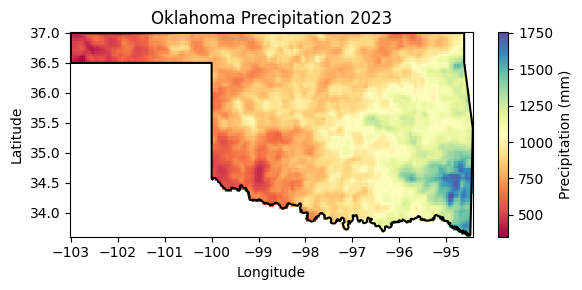

In [53]:
# Create figure
precip_raster.plot.imshow(figsize=(6,3), cmap='Spectral', add_colorbar=True,
                   cbar_kwargs={'label':'Precipitation (mm)'})
plt.plot(df['lon'], df['lat'],'-k')
plt.title('Oklahoma Precipitation 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.axis('equal')
plt.tight_layout()
plt.show()


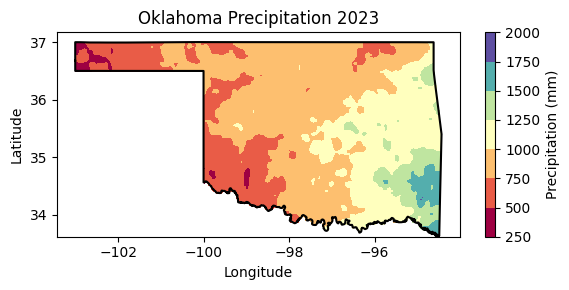

In [54]:
# Create contour figure
precip_raster.plot.contourf(figsize=(6,3), cmap='Spectral', add_colorbar=True,
                   cbar_kwargs={'label':'Precipitation (mm)'})
plt.plot(df['lon'], df['lat'],'-k')
plt.title('Oklahoma Precipitation 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.axis('equal')
plt.tight_layout()
plt.show()

In [55]:
# Find min and max precipitation
precip_img.reduceRegion(reducer = ee.Reducer.minMax(),
                        geometry = region.geometry(),
                        scale = 4_000).getInfo()

{'ppt_sum_max': 1753.4329500616004, 'ppt_sum_min': 349.43359203080763}

## Example 2: Min Reducer

The `.min()` reducer finds the minimum value. In this example we will determine the minimum and maximum land surface teperatures.

In [56]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
region = US_states.filter(ee.Filter.eq('NAME','Kansas'))

# Create mask
mask = ee.Image.constant(1).clip(region).mask()

In [57]:
# Load an image collection from PRISM
prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').filterDate('2010-01-01', '2020-12-31').filterBounds(region)
tmin_img = prism.select('tmin').reduce(ee.Reducer.min()).mask(mask)


In [58]:
# Save geotiff
tmin_filename = '../outputs/kansas_tmin_2010_2020.tif'
save_geotiff(tmin_img, tmin_filename, crs=4326, scale=4000, geom=region.geometry())


Saved image


In [59]:
# Read saved geotiff image
tmin_raster = xr.open_dataarray(tmin_filename).squeeze()


In [60]:
# Get the dictionary with all the metadata into a variable
# Print this variable to see the details
region_metadata = region.first().getInfo()

# Get coordinates of the county geometry
df = pd.DataFrame(region_metadata['geometry']['geometries'][1]['coordinates'][0])
df.columns = ['lon','lat']



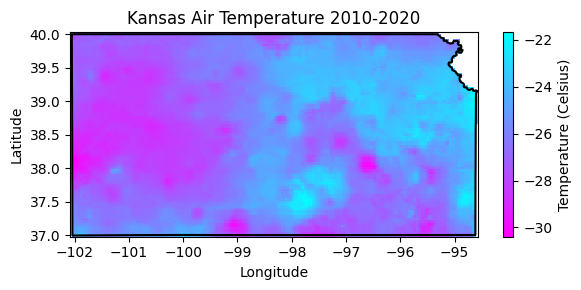

In [61]:
# Create figure
tmin_raster.plot.imshow(figsize=(6,3), cmap='cool_r', add_colorbar=True,
                   cbar_kwargs={'label':'Temperature (Celsius)'})
plt.plot(df['lon'], df['lat'],'-k')
plt.title('Kansas Air Temperature 2010-2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.axis('equal')
plt.tight_layout()
plt.show()


In [62]:
# Find lowest temperature
tmin_img.reduceRegion(reducer = ee.Reducer.min(),
                        geometry = region.geometry(),
                        scale = 4_000).getInfo()

{'tmin_min': -30.395000457763672}

>I still need to figure out how to obtain the coordinates of the location with the lowest temperature. If someone know the answer, please send me an e-mail or push the code to Github.

## Example 4: Max reducer

The `.max()` reducer find the maximum value. In this example we will use it to find the total spatial extent burned by wildfires over multiple days in southwest Kansas and northwest Oklahoma.

The Starbuck wildfire occurred in March 2017 and stands as one of the largest wildfires in Kansas history. The Starbuck wildfire started in Beaver county in Oklahoma and then spread across multiple Kansas counties, including Meade, Clark, and Comanche counties, ravaging over 662,000 acres of land that included ranches and residential areas. The fire's magnitude was so extensive that it not only caused significant ecological damage but also resulted in the loss of numerous cattle, property destruction, and challenged the resilience of local communities. The Starbuck wildfire highlighted the importance of community solidarity, the challenges of managing fire risk in rural regions, and the necessity for improved fire management, preparedness, and mitigation strategies.

In [8]:
# Load the US county boundaries.
counties = ee.FeatureCollection('TIGER/2016/Counties');

# Filter the counties by name and state (Kansas FIPS code is "20")
ks_counties = counties.filter(ee.Filter.Or(ee.Filter.eq('NAME', 'Clark'),
                                           ee.Filter.eq('NAME', 'Meade'),
                                           ee.Filter.eq('NAME', 'Comanche'))).filter(ee.Filter.eq('STATEFP', '20')) 

# Filter the counties by name and state (Oklahoma FIPS code is "40")
ok_counties = counties.filter(ee.Filter.Or(ee.Filter.eq('NAME', 'Beaver'),
                                           ee.Filter.eq('NAME', 'Harper'))).filter(ee.Filter.eq('STATEFP', '40')) 


## Combine the selected counties into a single geometry.
region = ks_counties.merge(ok_counties)

# Combined counties (not use in the tutorial)
region_union = region.union()

# Get bounding box of combined geometry
bbox = region.geometry().bounds()


In [96]:
# Load modis product
modis = ee.ImageCollection('MODIS/061/MOD14A1').filterDate('2017-03-01', '2017-03-31')
max_fire = modis.select('FireMask').reduce(ee.Reducer.max())


In [106]:
# Save GeoTIFF
max_fire_filename = '../outputs/starbuck_wildfire_.tiff'
save_geotiff(max_fire, filename=max_fire_filename, crs=4326, scale=1000, 
             geom=bbox, bands=[])

Saved image


In [ ]:
# Get geometry coordinates for all counties (this is a MultiPolygon object)
region_geom = region.geometry().getInfo()


In [154]:
# Read saved geotiff image
max_fire_raster = xr.open_dataarray(max_fire_filename).squeeze()


In [155]:
# Paletter of colors for the Enhanced Vegetation Index
hex_palette = ['#ffffff','#ff0000']

# Use the built-in ListedColormap function to do the conversion
cmap = colors.ListedColormap(hex_palette)


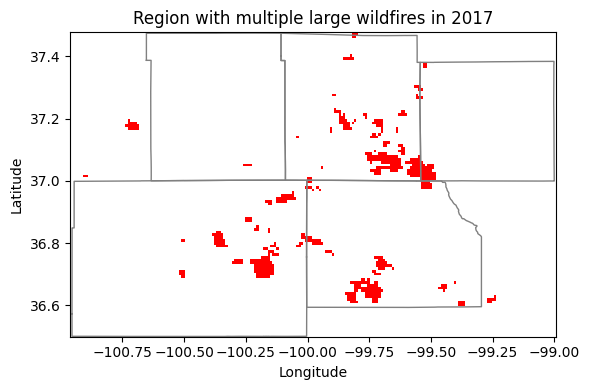

In [160]:
# Create figure
max_fire_raster.plot.imshow(figsize=(6,4), cmap=cmap, add_colorbar=False)

for r in region_geom['coordinates']:
    lon,lat = zip(*r[0])
    plt.plot(list(lon), list(lat), linestyle='-', linewidth=1, color='grey')
    
plt.title('Region with multiple large wildfires in 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.axis('equal')
plt.tight_layout()
plt.show()

## Example 5: Median reducer

The median reducer computes the typicalvalue of a set of numbers. It's often used to aggregate pixel values across images or image collections.

In this example we will compute the median enhanced vegetation index for a county and we learn how to:

- filter a FeatureCollection,
- compute the median of an ImageCollection, 
- create, apply, and update a mask,
- retrieve, save, and read a geotiff image


In [63]:
# US Counties dataset
US_counties = ee.FeatureCollection("TIGER/2018/Counties") 

# Select county of interest
county = US_counties.filter(ee.Filter.eq('GEOID','20161'))

# Create mask
mask = ee.Image.constant(1).clip(county).mask()


In [64]:
# Modis EVI
modis_evi = ee.ImageCollection('MODIS/MCD43A4_006_EVI')

evi_img = modis_evi.filterDate('2021-04-01', '2021-09-30') \
         .select('EVI').filterBounds(county).median()

# Create mask for region
evi_img = evi_img.mask(mask)

# Update mask to avoid water bodies (wich typically have evi<0.2)
evi_img = evi_img.updateMask(evi_img.gt(0.2))


In [65]:
# Set visualization parameters.
# https://colorbrewer2.org/#type=sequential&scheme=YlOrBr&n=7
evi_palette = ['#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901',
             '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01',
             '#012E01', '#011D01', '#011301']
evi_cmap = colors.ListedColormap(evi_palette)


In [66]:
# Save geotiff image
evi_filename = '../outputs/evi_riley_county.tif'
save_geotiff(evi_img, evi_filename, crs=4326, scale=250, 
             geom=county.geometry(), bands=['EVI'])

Saved image


In [67]:
# Read GeoTiff file using the Xarray package
evi_raster = xr.open_dataarray(evi_filename).squeeze()


In [68]:
# Get coordinates of the county geometry
df = pd.DataFrame(county.first().getInfo()['geometry']['coordinates'][0])
df.columns = ['lon','lat']
df.head()


,lon,lat
0,-96.961683,39.220095
1,-96.961369,39.220095
2,-96.956566,39.220005
3,-96.954188,39.220005
4,-96.952482,39.220005


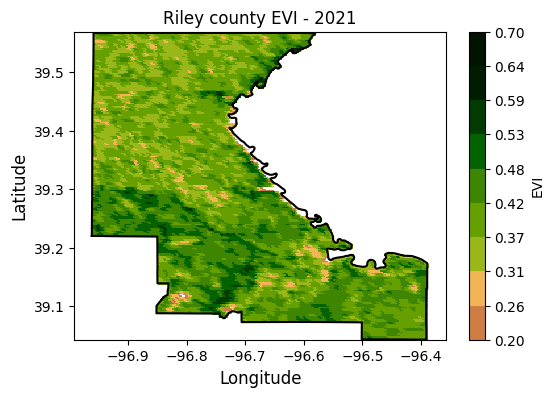

In [69]:
# Create figure

plt.figure(figsize=(6,4))
evi_raster.plot.imshow(cmap=evi_cmap, vmin=0.2, vmax=0.7, 
                       levels=10, cbar_kwargs={'label':'EVI', 'format':"{x:.2f}"}) # Can also pass robust=True
plt.plot(df['lon'], df['lat'],'-k')
plt.title('Riley county EVI - 2021', size=12)
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)
plt.xlim([-97,-96.35])
plt.ylim([39, 39.6])
plt.axis('equal')
#plt.savefig('../outputs/riley_county_median_evi.jpg', dpi=300)
plt.show()


## Example 6: Mean reducer

The mean reducer computes the pixel-wise average value of a set of images in a collection. It's often used to aggregate pixel values across images or image collections. In this exercise we will compute the mean NDVI for each pixel over a watershed.


In [82]:
# Read US watersheds using hydrologic unit codes (HUC)
watersheds = ee.FeatureCollection("USGS/WBD/2017/HUC12")
mcdowell_creek = watersheds.filter(ee.Filter.eq('huc12', '102701010204')).first()

# Get geometry so that we can plot the boundary
mcdowell_creek_geom = mcdowell_creek.geometry().getInfo()

# Create mask for the map
mask = ee.Image.constant(1).clip(mcdowell_creek).mask()

In [84]:
# Get watershed boundaries
df_mcdowell_creek_bnd = pd.DataFrame(np.squeeze(mcdowell_creek_geom['coordinates']),
                                     columns=['lon','lat'])
# Inspect dataframe
df_mcdowell_creek_bnd.head()


,lon,lat
0,-96.552986,39.093157
1,-96.553307,39.093741
2,-96.553592,39.094234
3,-96.553683,39.094391
4,-96.553988,39.094490


In [85]:
# Get collection for Terra Vegetation Indices 16-Day Global 500m
start_date = '2022-01-01'
end_date = '2022-12-31'
collection = ee.ImageCollection('MODIS/006/MOD13A1').filterDate(start_date, end_date)

In [86]:
# Reduce the collection to an image with a median reducer.
ndvi_mean = collection.mean().multiply(0.0001).clip(mcdowell_creek)

# Apply mask
ndvi_mean = ndvi_mean.mask(mask)

# Save geotiff image
ndvi_filename = '../outputs/ndvi_mean_mcdowell_creek.tif'
save_geotiff(ndvi_mean, ndvi_filename, crs=4326, scale=250, 
             geom=mcdowell_creek.geometry(), bands=['NDVI'])


Saved image


In [87]:
# Define NDVI colormap
hex_palette = ['#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901',
             '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01',
             '#012E01', '#011D01', '#011301']

# Use the built-in ListedColormap function to do the conversion
ndvi_cmap = colors.ListedColormap(hex_palette)


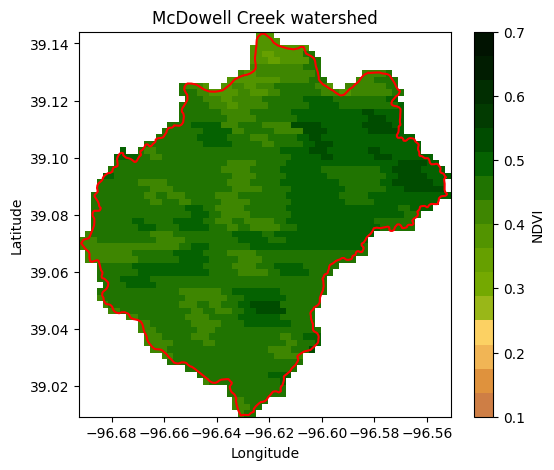

In [88]:
# Read GeoTiff file using the Xarray package
raster = xr.open_dataarray(filename).squeeze()

plt.figure(figsize=(6,5))
raster.plot(cmap=ndvi_cmap, cbar_kwargs={'label':'NDVI'}, vmin=0.1, vmax=0.7)
plt.plot(df_mcdowell_creek_bnd['lon'], df_mcdowell_creek_bnd['lat'], color='r')
plt.title('McDowell Creek watershed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Example 7: Count reducer over a region

The count reducer tallies the number of values, useful for counting the number of observations or pixels within a region that meet certain criteria. In this example we will find the area of Kansas covered by grasslands. If you thought that Kansas was mostly covered by cropland, then you are up for a surprise.


In [36]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
region = US_states.filter(ee.Filter.inList('NAME',['Kansas']))


In [37]:
# Land use for 2021
land_use = ee.ImageCollection('USDA/NASS/CDL')\
             .filter(ee.Filter.date('2020-01-01', '2021-12-31')).first().clip(region)

# Select cropland layer
cropland = land_use.select('cropland')


In [39]:
# Select pixels for a cover
land_cover_value = 176
land_cover_img = cropland.eq(land_cover_value).selfMask()


In [41]:
# Save geotiff image
land_cover_filename = '../outputs/land_cover_kansas.tif'
save_geotiff(land_cover_img, land_cover_filename, crs=4326, scale=250, 
             geom=region.geometry())

Saved image


In [42]:
# Read GeoTiff file using the Xarray package
land_cover_raster = xr.open_dataarray(land_cover_filename).squeeze()


In [52]:
# Get the dictionary with all the metadata into a variable
# Print this variable to see the details
region_metadata = region.first().getInfo()

# Get coordinates of the county geometry
df = pd.DataFrame(region_metadata['geometry']['geometries'][1]['coordinates'][0])
df.columns = ['lon','lat']


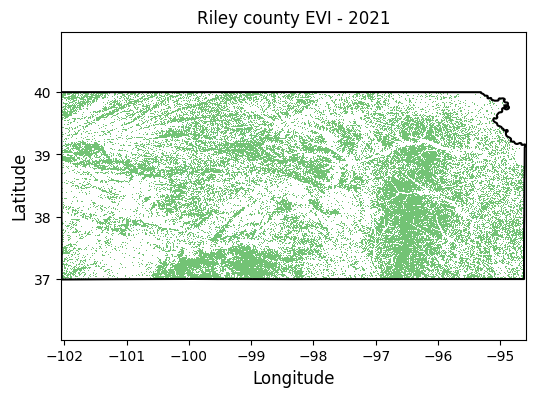

In [56]:
# Create figure

plt.figure(figsize=(6,4))
land_cover_raster.plot.imshow(cmap='Greens', add_colorbar=False)
plt.plot(df['lon'], df['lat'],'-k')
plt.title('Riley county EVI - 2021', size=12)
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)
plt.xlim([-97,-96.35])
plt.ylim([39, 39.6])
plt.axis('equal')
#plt.savefig('../outputs/riley_county_median_evi.jpg', dpi=300)
plt.show()

In [63]:
# Reduce the collection and compute area of land cover
# Kansas has an area of 213,100 square kilometers

# Applyreducer
land_cover_count = land_cover_img.reduceRegion(reducer=ee.Reducer.count(),
                                               geometry=region.geometry(),
                                               scale=250)

land_cover_pixels = land_cover_count.get('cropland').getInfo()
print(f'There are a total of {land_cover_pixels} under grassland at 250 m spatial resolution')

state_area = 213_000 # km^2
state_fraction = (land_cover_pixels*250**2) / 10**6 / state_area 
print(f'Kansas has a {round(state_fraction*100)} % of the area covered by grassland')



There are a total of 1428376 under grassland at 250 m spatial resolution
Kansas has a 42 % of the area covered by grassland


The `reduceRegion()` function applies a reducer to all the pixels in a specified region.
Altrnatively you can pass options as keyword arguments using dictionary, like so:

```python
land_cover_count = land_cover_img.reduceRegion(**{
    'reducer': ee.Reducer.count(),
    'geometry': region.geometry(),
    'scale': 250})
```